In [1]:
# set width = 95%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# heatmaps with color *and* marker size, useful for correlation plots
!{sys.executable} -m pip install heatmapz -q
from heatmap import heatmap, corrplot

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, **kwargs):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
    if tight_layout==True:
        plt.tight_layout()
    elif tight_layout==False:
        pass
    else:
        plt.tight_layout(pad=tight_layout)
    plt.savefig(path, format=fig_extension, dpi=resolution,**kwargs)

In [3]:
# Plotting Functions
# ...

# Get the data

## Description from Kaggle
### Plant_<1,2>_Generation_Data.csv
Solar power generation data for one plant gathered at 15 minutes intervals over a 34 days period.

**DATE_TIME**
Date and time for each observation. Observations recorded at 15 minute intervals.

**PLANT_ID**
Plant ID - this will be common for the entire file.

**SOURCE_KEY**
Source key in this file stands for the inverter id.

**DC_POWER**
Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

**AC_POWER**
Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

**DAILY_YIELD**
Daily yield is a cumulative sum of power generated on that day, till that point in time.

**TOTAL_YIELD**
This is the total yield for the inverter till that point in time.

### Plant_<1,2>_Weather_Sensor_Data.csv
Weather sensor data gathered for one solar plant every 15 minutes over a 34 days period.

**DATE_TIME**
Date and time for each observation. Observations recorded at 15 minute intervals.

**PLANT_ID**
Plant ID - this will be common for the entire file.

**SOURCE_KEY**
Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.

**AMBIENT_TEMPERATURE**
This is the ambient temperature at the plant.

**MODULE_TEMPERATURE**
There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.

**IRRADIATION**
Amount of irradiation for the 15 minute interval.

In [4]:
DATA_PATH = PROJECT_ROOT_DIR + "/Data Files"

def load_power_data(plant_num = 1,power_path=DATA_PATH,plant_tot=False):
    if isinstance(plant_num, list):
        dfs = []
        for plant_ind in plant_num:
            dfs.append(load_power_data(plant_ind,power_path,plant_tot))
        return pd.concat(dfs)
    csv_path = os.path.join(power_path, "Plant_{:d}_Generation_Data.csv".format(plant_num))
    df = pd.read_csv(csv_path)
    df["PLANT_ID"] = plant_num
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%d-%m-%Y %H:%M")
    except: 
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%Y-%m-%d %H:%M:%S")
    if plant_tot:
        df = df.groupby(['DATE_TIME','PLANT_ID']).agg('sum').reset_index()
    else:
        # map inverter codes --> numbers (*not* distinct for different plants)
        # stability extension: hard-code map to ensure consistency across data sets
        df['inverter #']=df['SOURCE_KEY'].factorize()[0]+1
        df.drop("SOURCE_KEY",axis=1, inplace=True)
#     df.set_index('DATE_TIME', inplace=True)
    return df

def load_weather_data(plant_num = 1,weather_path=DATA_PATH):
    if isinstance(plant_num, list):
        dfs = []
        for plant_ind in plant_num:
            dfs.append(load_weather_data(plant_ind,weather_path))
        return pd.concat(dfs)
    csv_path = os.path.join(weather_path, "Plant_{:d}_Weather_Sensor_Data.csv".format(plant_num))
    df = pd.read_csv(csv_path)
    df["PLANT_ID"] = plant_num
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%d-%m-%Y %H:%M")
    except: 
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%Y-%m-%d %H:%M:%S")
    df.drop("SOURCE_KEY",axis=1, inplace=True)
#     df.set_index('DATE_TIME', inplace=True)
    return df

def load_power_and_weather_data(plant_num = 1,weather_path=DATA_PATH,power_path=DATA_PATH,plant_tot=False):
    weather = load_weather_data(plant_num,weather_path)
    power = load_power_data(plant_num,power_path,plant_tot)
    return power.merge(weather,how='outer',on=['PLANT_ID','DATE_TIME'])

# define aliases for more readable plot labels 
col_alias = {'DATE_TIME':'time (15min interval)', 'PLANT_ID':'plant #', 'inverter #':'inverter #',
             'DC_POWER':'DC power (kW)', 'AC_POWER':'AC power (kW)',
             'DAILY_YIELD':"cumulative day's yield", 'TOTAL_YIELD':'cumulative yield',
             'AMBIENT_TEMPERATURE':'ambient temperature ($\\degree C$)',
             'MODULE_TEMPERATURE':'panel temperature ($\\degree C$)', 'IRRADIATION':'irradiation'}

In [5]:
power = load_power_data([1,2])
# power.head()
power_ave = load_power_data([1,2],plant_tot=True)
# power_ave.head()
weather = load_weather_data([1,2])
# weather.head()

In [6]:
solar = load_power_and_weather_data([1,2])
solar.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,inverter #,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,1,0.0,0.0,0.0,6259559.0,1.0,25.184316,22.857507,0.0
1,2020-05-15,1,0.0,0.0,0.0,6183645.0,2.0,25.184316,22.857507,0.0
2,2020-05-15,1,0.0,0.0,0.0,6987759.0,3.0,25.184316,22.857507,0.0
3,2020-05-15,1,0.0,0.0,0.0,7602960.0,4.0,25.184316,22.857507,0.0
4,2020-05-15,1,0.0,0.0,0.0,7158964.0,5.0,25.184316,22.857507,0.0


In [7]:
solar_ave = load_power_and_weather_data([1,2],plant_tot=True)
solar_ave.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1,0.0,0.0,0.0,143581676.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,1,0.0,0.0,0.0,143581676.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,1,0.0,0.0,0.0,143581676.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,1,0.0,0.0,0.0,143581676.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,1,0.0,0.0,0.0,150761642.0,24.621525,22.165423,0.0


In [8]:
# rows with missing data in outer join. 
# Note: power and weather have no null values
solar[solar.isnull().any(1)]

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,inverter #,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
38544,2020-06-03 14:00:00,1,7003.0,685.8,5601.0,6330385.0,2.0,NaN,NaN,NaN
38545,2020-06-03 14:00:00,1,7204.0,705.4,5685.0,6419961.0,10.0,NaN,NaN,NaN
38546,2020-06-03 14:00:00,1,7545.0,738.7,5579.0,6928448.0,18.0,NaN,NaN,NaN
38547,2020-06-03 14:00:00,1,7946.0,777.8,5541.0,7152815.0,19.0,NaN,NaN,NaN
136476,2020-05-20 23:00:00,1,NaN,NaN,NaN,NaN,NaN,23.830852,21.024118,0.000000
136477,2020-05-20 23:15:00,1,NaN,NaN,NaN,NaN,NaN,23.701162,20.786399,0.000000
136478,2020-05-20 23:30:00,1,NaN,NaN,NaN,NaN,NaN,23.589626,20.572882,0.000000
136479,2020-05-20 23:45:00,1,NaN,NaN,NaN,NaN,NaN,23.569009,20.622103,0.000000
136480,2020-05-21 00:00:00,1,NaN,NaN,NaN,NaN,NaN,23.497382,20.584137,0.000000
136481,2020-05-21 00:15:00,1,NaN,NaN,NaN,NaN,NaN,23.228943,20.230347,0.000000


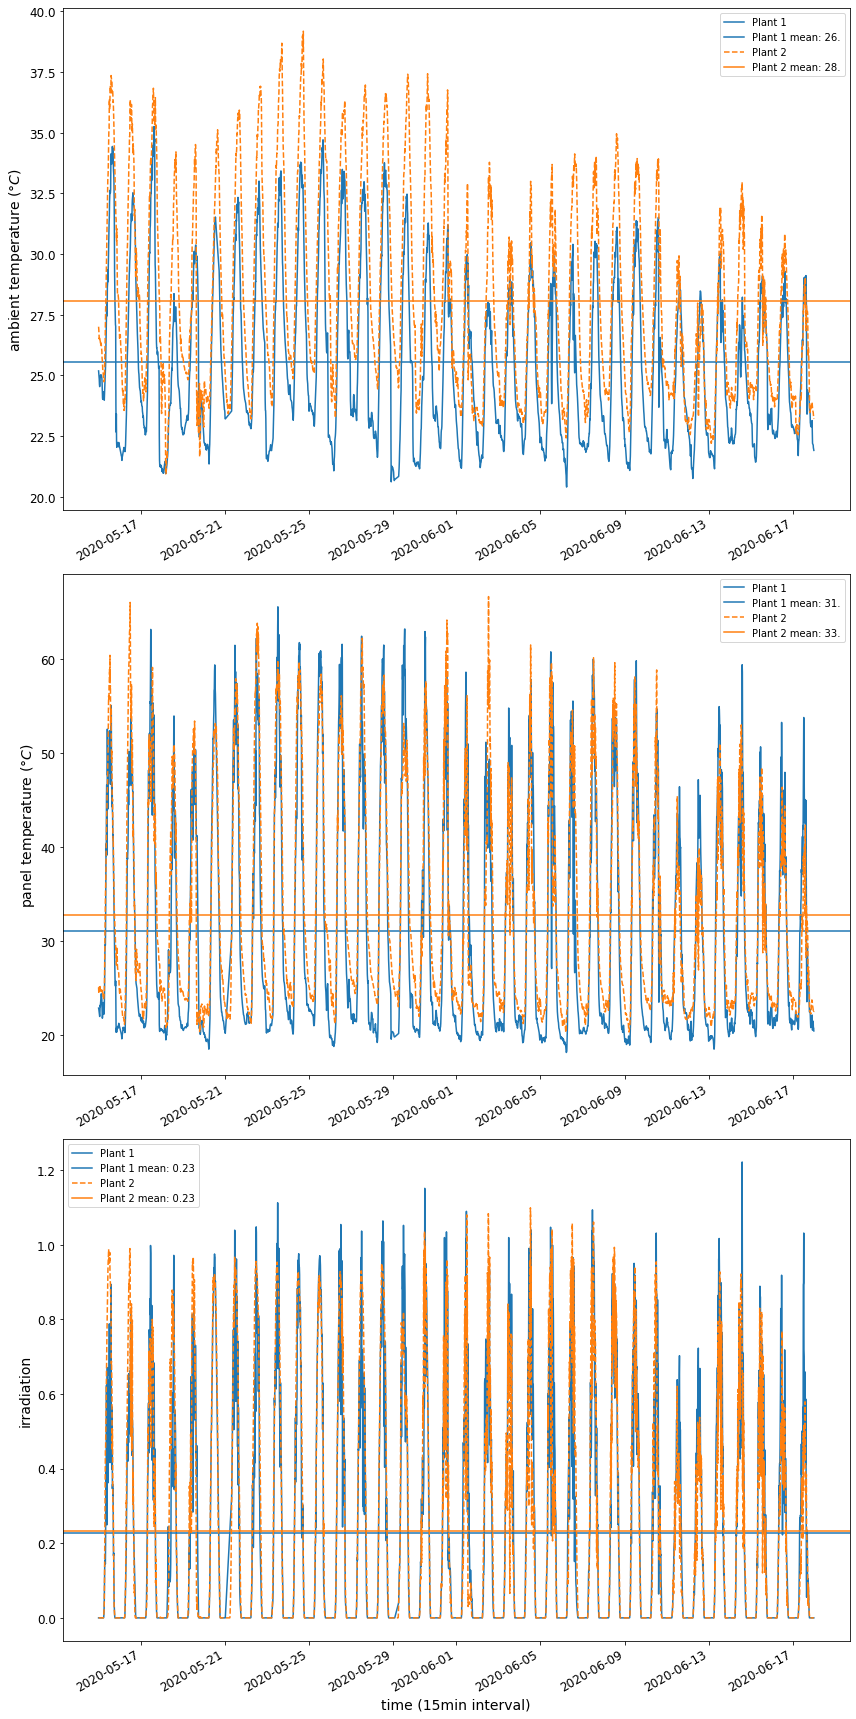

In [9]:
# compare weather data for the plants
fig, axs = plt.subplots(3,figsize=(12,24))
cols = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']
for ind in range(0,len(cols)):
    weather[weather["PLANT_ID"]==1].plot(kind='line',x="DATE_TIME",y=cols[ind],ax=axs[ind],label="Plant 1",style="-")
    mean_plant_1 = weather.loc[weather["PLANT_ID"]==1,cols[ind]].agg('mean')
    axs[ind].axhline(mean_plant_1,label="Plant 1 mean: {:#0.2g}".format(mean_plant_1),color="C{}".format(1-1))
    weather[weather["PLANT_ID"]==2].plot(kind='line',x="DATE_TIME",y=cols[ind],ax=axs[ind],label="Plant 2",style="--")
    mean_plant_2 = weather.loc[weather["PLANT_ID"]==2,cols[ind]].agg('mean')
    axs[ind].axhline(mean_plant_2,label="Plant 2 mean: {:#0.2g}".format(mean_plant_2),color="C{}".format(2-1))
    axs[ind].set_ylabel(col_alias[cols[ind]])
    axs[ind].legend()
    if ind==len(cols)-1:
        axs[ind].set_xlabel(col_alias["DATE_TIME"])
    else:
        axs[ind].set_xlabel('')
save_fig("Weather vs time by plant")

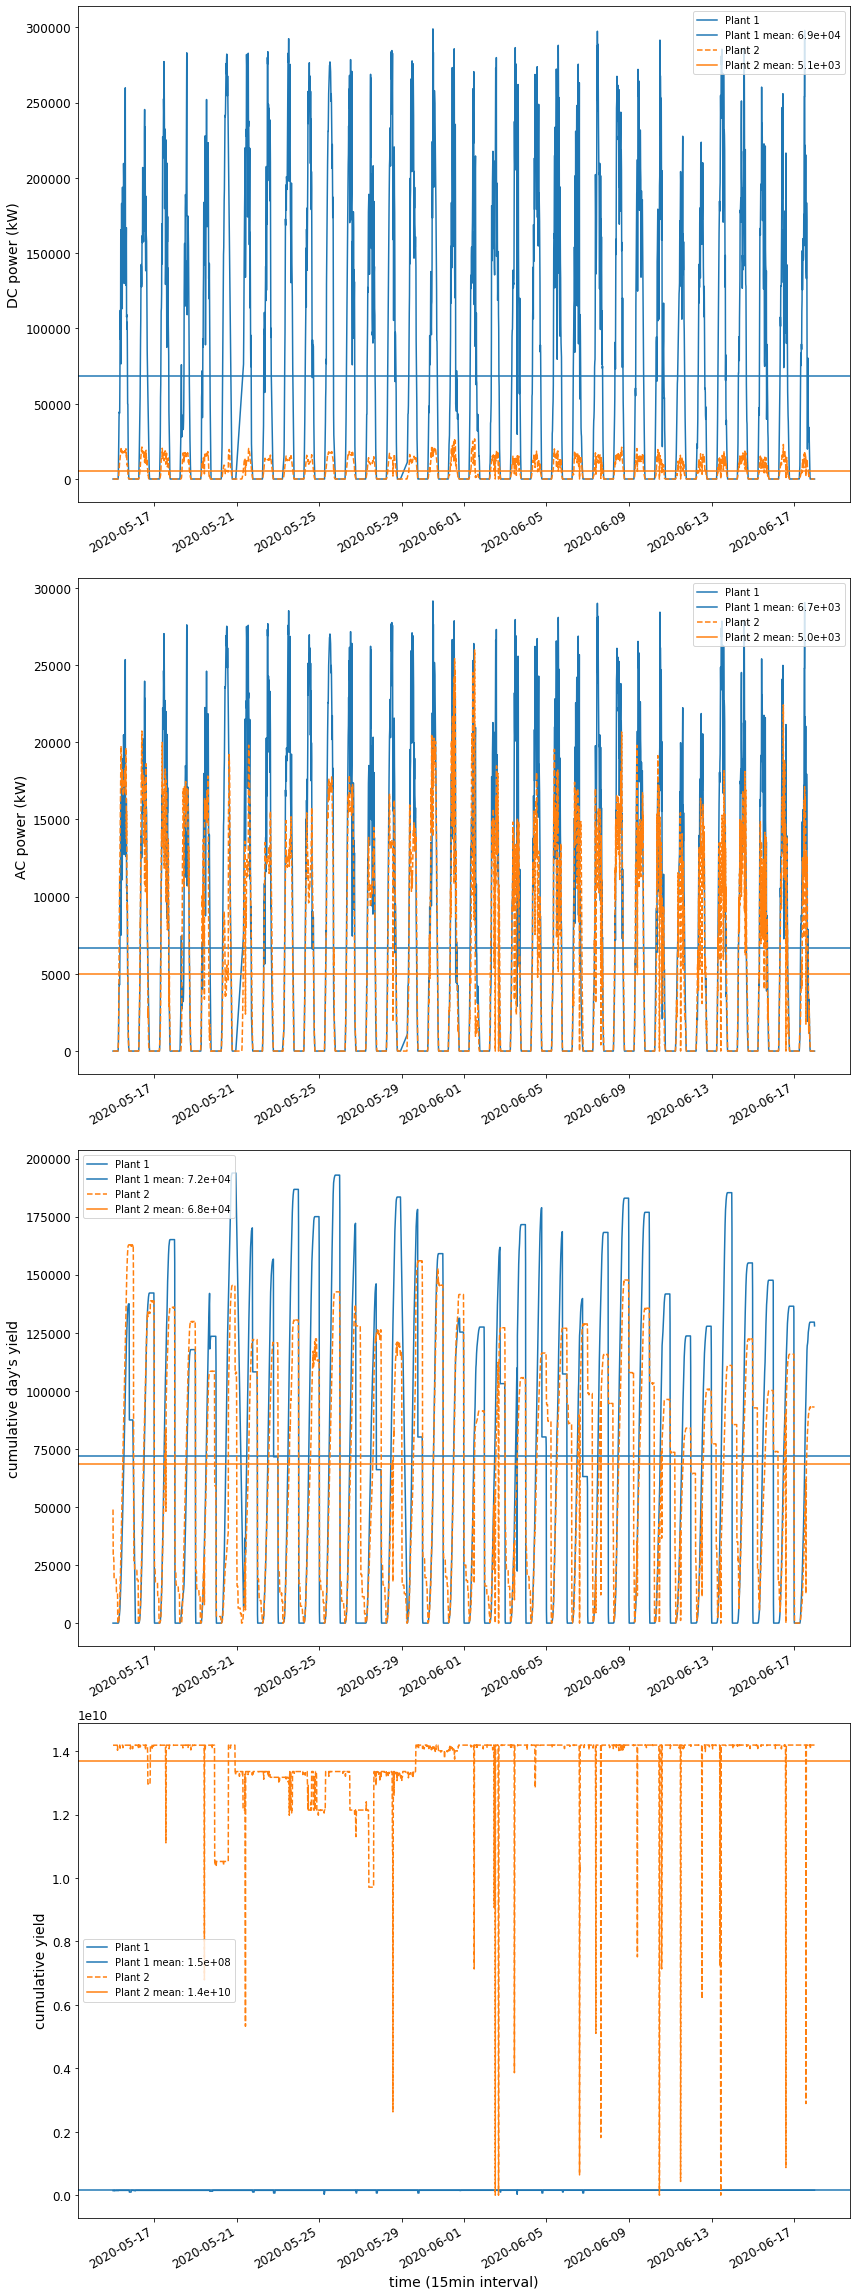

In [10]:
# compare (total) power data for the plants
cols = ['DC_POWER', 'AC_POWER','DAILY_YIELD', 'TOTAL_YIELD']
fig, axs = plt.subplots(len(cols),figsize=(12,8*len(cols)))
for ind in range(0,len(cols)):
    power_ave[power_ave["PLANT_ID"]==1].plot(kind='line',x="DATE_TIME",y=cols[ind],ax=axs[ind],label="Plant 1",style="-")
    mean_plant_1 = power_ave.loc[power_ave["PLANT_ID"]==1,cols[ind]].agg('mean')
    axs[ind].axhline(mean_plant_1,label="Plant 1 mean: {:#0.2g}".format(mean_plant_1),color="C{}".format(1-1))
    power_ave[power_ave["PLANT_ID"]==2].plot(kind='line',x="DATE_TIME",y=cols[ind],ax=axs[ind],label="Plant 2",style="--")
#     axs[ind].axhline(power_ave.loc[power_ave["PLANT_ID"]==2,cols[ind]].agg('mean'),label="_2_mean",color="C{}".format(2-1))
    mean_plant_2 = power_ave.loc[power_ave["PLANT_ID"]==2,cols[ind]].agg('mean')
    axs[ind].axhline(mean_plant_2,label="Plant 2 mean: {:#0.2g}".format(mean_plant_2),color="C{}".format(2-1))
    axs[ind].set_ylabel(col_alias[cols[ind]])
    axs[ind].legend()
    if ind==len(cols)-1:
        axs[ind].set_xlabel(col_alias["DATE_TIME"])
    else:
        axs[ind].set_xlabel('')
save_fig("Power vs time by plant")

## Observations & Notes
- What's up with cumulative yield?
- Weather at the two plants is fairly similar
    - Plant #2 is ~2.5 degree warmer
    - Very similar irradiation
- Power more different
    - Plant #2 generates little DC power, and ~15% less AC power
- TODO
    - check for missing times during night
    - investigate missing power-weather pairs
    - plot averages by day and by hour-of-day
    - plot comparison for different inverters
    - histogram to identify performance outliers